# Re Evaluate the data

In [58]:
import sys
sys.path.insert(0, '../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import modules.missing as ms
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif

## Load Data

In [56]:
app_train = pd.read_csv('../data/application_train_cleaned.csv')
bb = pd.read_csv('../data/bureau_balance.csv')
bureau = pd.read_csv('../data/bureau_clean.csv')
ccb = pd.read_csv('../data/credit_card_balance_clean.csv')
installments = pd.read_csv('../data/installments_payments_clean.csv')
pos_cash = pd.read_csv('../data/pos_cash_balance_clean.csv')
previous = pd.read_csv('../data/previous_application_clean1.csv')

## Bureau data group by and joining

bb aggragate to show average MONTHS_BALANCE()

In [57]:
app_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.262949,2.0,2.0,2.0,2.0,-1134.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622246,1.0,0.0,1.0,0.0,-828.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,1,1,1,1,1,0,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,0.555912,0.0,0.0,0.0,0.0,-815.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,1,1,0,1,0,0,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,0.650442,2.0,0.0,2.0,0.0,-617.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,1,1,0,1,0,0,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,0.322738,0.0,0.0,0.0,0.0,-1106.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,0.032561,-9327,-236,-8456.0,-1982,1,1,0,1,0,0,1.0,1,1,THURSDAY,15,0,0,0,0,0,0,Services,0.681632,0.0,0.0,0.0,0.0,-273.0
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,225000.0,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,0.025164,-20775,365243,-4388.0,-4090,1,0,0,1,1,0,1.0,2,2,MONDAY,8,0,0,0,0,0,0,XNA,0.115992,0.0,0.0,0.0,0.0,0.0
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,585000.0,Unaccompanied,Working,Higher education,Separated,House / apartment,0.005002,-14966,-7921,-6737.0,-5150,1,1,0,1,0,1,1.0,3,3,THURSDAY,9,0,0,0,0,1,1,School,0.535722,6.0,0.0,6.0,0.0,-1909.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,319500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.005313,-11961,-4786,-2562.0,-931,1,1,0,1,0,0,2.0,2,2,WEDNESDAY,9,0,0,0,1,1,0,Business Entity Type 1,0.514163,0.0,0.0,0.0,0.0,-322.0


In [46]:
# aggreagate bureau balance Months' balance with mean for every unique bureau id
bb_agg = bb.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].mean().reset_index(name='AVG_MONTHS_BALANCE')

# join aggregated bureau balance with bureau
bureau_semi_join = pd.merge(bureau, bb_agg, on='SK_ID_BUREAU', how='left')

# aggregate current credit amount and current debt(on credit bureau) with sum for every unique current application id
bureau_agg = bureau_semi_join.groupby('SK_ID_CURR')[['AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT']].sum().reset_index()

## Join bureau and application train

In [47]:
# left join application train with aggregated bureau 
train_bureau = pd.merge(app_train, bureau_agg, on='SK_ID_CURR', how='left')

## Payment installments aggregation and feature creation

In [48]:
# installment payment data joining and aggregating
installments_agg = installments.groupby(['SK_ID_PREV', 'SK_ID_CURR'])[['AMT_INSTALMENT', 'AMT_PAYMENT']].sum().reset_index()

# Differences between annuity installment and the client actually paid, 
# the more the value is far away from 0 the more probability of client to be a bad client 
installments_agg['DIFF_INSTALLMENT_PAYMENT'] = installments_agg['AMT_INSTALMENT'] - installments_agg['AMT_PAYMENT']
installments_agg = installments_agg.drop(columns='SK_ID_CURR', axis=1)

## Join payment isntallments with previous application

In [49]:
# join installment with previous application
prev_installments = pd.merge(previous, installments_agg, on='SK_ID_PREV', how='left')

## Credit Card Balance Aggregate and Join

In [50]:
ccb_agg = ccb.groupby('SK_ID_PREV')[['AMT_BALANCE', 'AMT_PAYMENT_TOTAL_CURRENT']].sum().reset_index()

prev_ccb = pd.merge(prev_installments, ccb_agg, on='SK_ID_PREV', how='left')

## Pos Cash Balance Aggregate and Join

In [51]:
pc_agg = pos_cash.groupby('SK_ID_PREV')['SK_DPD'].mean().reset_index(name='AVERAGE_DPD')

prev_pc = pd.merge(prev_ccb, pc_agg, on='SK_ID_PREV', how='left')

## Train Full

In [52]:
train_full = pd.merge(train_bureau, prev_pc, on='SK_ID_CURR', how='left')

In [61]:
train_full.to_csv('../data/train_full.csv', index=False)

In [10]:
pd.set_option('display.max_columns', None)

display(train_full.sample(10))
print(f'Application train data contains: \n{train_full.shape[0]} rows and {train_full.shape[1]} columns')
print(f'\nApplication train data information:\n')
print(train_full.info())
print(f'\nStatistical Summary of numerical columns:\n')

numerical = train_full.select_dtypes(include='number')
display(numerical.describe())

categorical = train_full.select_dtypes(include='object')
display(categorical.describe())

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START_x,HOUR_APPR_PROCESS_START_x,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,SK_ID_PREV,NAME_CONTRACT_TYPE_y,AMT_ANNUITY_y,AMT_APPLICATION,AMT_CREDIT_y,AMT_GOODS_PRICE_y,WEEKDAY_APPR_PROCESS_START_y,HOUR_APPR_PROCESS_START_y,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,AMT_INSTALMENT,AMT_PAYMENT,DIFF_INSTALLMENT_PAYMENT,AMT_BALANCE,AMT_PAYMENT_TOTAL_CURRENT,AVERAGE_DPD
905633,326279,0,Cash loans,F,N,Y,0,81000.0,552555.0,16879.5,477000.0,Unaccompanied,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,0.030755,-20054,365243,-4130.0,-3325,1,0,0,1,0,0,2.0,2,2,TUESDAY,13,0,0,0,0,0,0,XNA,0.562714,0.0,0.0,0.0,0.0,-1364.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3209800.500,548199.00,2543816.0,Consumer loans,9874.890,105840.000,105840.0,105840.000,SATURDAY,9.0,Y,1.0,XAP,Refused,-1221.0,XNA,LIMIT,Repeater,Construction Materials,POS,XNA,Stone,20.0,Construction,12.0,low_normal,POS industry with interest,NaN,NaN,NaN,NaN,NaN,NaN
42183,110511,0,Cash loans,M,N,Y,0,112500.0,210456.0,16758.0,166500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Single / not married,With parents,0.025164,-8207,-478,-886.0,-893,1,1,0,1,0,0,1.0,2,2,MONDAY,14,0,0,0,1,1,0,Business Entity Type 3,0.286269,0.0,0.0,0.0,0.0,-180.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,1782063.0,Revolving loans,0.000,0.000,0.0,0.000,WEDNESDAY,12.0,Y,1.0,XAP,Canceled,-180.0,XNA,XAP,Repeater,XNA,XNA,XNA,Credit and cash offices,-1.0,XNA,0.0,XNA,Card Street,NaN,NaN,NaN,NaN,NaN,NaN
449979,212487,0,Cash loans,F,Y,Y,0,270000.0,244584.0,16051.5,193500.0,Unaccompanied,Working,Secondary / secondary special,Separated,House / apartment,0.018209,-15039,-2742,-9167.0,-1083,1,1,0,1,0,0,1.0,3,3,TUESDAY,8,0,0,0,0,0,0,Self-employed,0.554173,1.0,0.0,1.0,0.0,-2148.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3110562.405,1643719.86,1083827.0,Consumer loans,12494.070,96061.500,80815.5,96061.500,WEDNESDAY,12.0,Y,1.0,XAP,Approved,-2148.0,Cash through the bank,XAP,New,Mobile,POS,XNA,Country-wide,1500.0,Consumer electronics,8.0,high,POS household with interest,174841.020,104091.930,70749.090,NaN,NaN,205.766667
1176476,392076,0,Cash loans,M,Y,N,0,135000.0,1081143.0,43006.5,994500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.003069,-15931,-4470,-2564.0,-5143,1,1,0,1,0,0,2.0,3,3,THURSDAY,11,0,0,0,0,1,1,Restaurant,0.498630,0.0,0.0,0.0,0.0,-1130.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,2801919.0,Cash loans,0.000,0.000,0.0,0.000,FRIDAY,14.0,Y,1.0,XNA,Canceled,-370.0,XNA,XAP,Repeater,XNA,XNA,XNA,Credit and cash offices,-1.0,XNA,0.0,XNA,Cash,NaN,NaN,NaN,N

Application train data contains: 
1430155 rows and 98 columns

Application train data information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1430155 entries, 0 to 1430154
Data columns (total 98 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   SK_ID_CURR                    1430155 non-null  int64  
 1   TARGET                        1430155 non-null  int64  
 2   NAME_CONTRACT_TYPE_x          1430155 non-null  object 
 3   CODE_GENDER                   1430155 non-null  object 
 4   FLAG_OWN_CAR                  1430155 non-null  object 
 5   FLAG_OWN_REALTY               1430155 non-null  object 
 6   CNT_CHILDREN                  1430155 non-null  int64  
 7   AMT_INCOME_TOTAL              1430155 non-null  float64
 8   AMT_CREDIT_x                  1430155 non-null  float64
 9   AMT_ANNUITY_x                 1430155 non-null  float64
 10  AMT_GOODS_PRICE_x             1430155 non-null  fl

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START_x,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,SK_ID_PREV,AMT_ANNUITY_y,AMT_APPLICATION,AMT_CREDIT_y,AMT_GOODS_PRICE_y,HOUR_APPR_PROCESS_START_y,NFLAG_LAST_APPL_IN_DAY,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,DIFF_INSTALLMENT_PAYMENT,AMT_BALANCE,AMT_PAYMENT_TOTAL_CURRENT,AVERAGE_DPD
count,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.254670e+06,1.254670e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,8.205850e+05,8.205850e+05,8.205850e+05,7.828500e+04,7.828500e+04,769614.000000
mean,2.784702e+05,8.624240e-02,4.038870e-01,1.736036e+05,5.893386e+05,2.704027e+04,5.289922e+05,2.079102e-02,-1.631495e+04,6.860209e+04,-5.001275e+03,-3.034492e+03,9.999993e-01,8.067175e-01,1.824732e-01,9.989917e-01,2.825792e-01,7.195793e-02,2.149003e+00,2.058179e+00,2.036176e+00,1.199401e+01,1.229377e-02,4.435953e-02,3.626041e-02,7.368082e-02,2.220151e-01,1.738609e-01,5.110974e-01,1.538150e+00,1.532512e-01,1.520324e+00,1.074548e-01,-1.076470e+03,6.992249e-05,7.362195e-01,7.551629e-05,1.360202e-02,8.985390e-02,2.244512e-04,7.469540e-02,3.201751e-03,5.523877e-05,2.122148e-03,2.097675e-06,2.110960e-03,1.736175e-03,7.586590e-04,6.864291e-03,1.622202e-04,4.954708e-03,4.398125e-04,4.083473e-04,2.349396e-04,2.048573e+06,6.631244e+05,1.922744e+06,1.239553e+04,1.752436e+05,1.963539e+05,1.752686e+05,1.247893e+01,9.964321e-01,-8.803670e+02,3.149878e+02,1.256367e+01,2.328081e+05,2.352289e+05,-2.420824e+03,2.035212e+06,2.677531e+05,1.021295
std,1.028021e+05,2.807218e-01,7.165176e-01,1.983303e+05,3.874204e+05,1.404126e+04,3.559720e+05,1.339810e-02,4.346737e+03,1.451967e+05,3.551626e+03,1.507182e+03,8.361967e-04,3.948728e-01,3.862342e-01,3.173746e-02,4.502536e-01,2.584183e-01,9.001609e-01,4.963435e-01,4.891555e-01,3.233163e+00,1.101937e-01,2.058927e-01,1.869375e-01,2.612509e-01,4.156014e-01,3.789899e-01,1.918513e-01,2.525672e+00,4.646596e-01,2.503920e+00,3.780070e-01,8.036990e+02,8.361678e-03,4.406818e-01,8.689686e-03,1.158318e-01,2.859724e-01,1.498002e-02,2.628993e-01,5.649338e-02,7.432076e-03,4.601788e-02,1.448334e-03,4.589668e-02,4.163127e-02,2.753333e-02,8.256620e-02,1.273554e-02,7.021511e-02,2.096710e-02,2.020349e-02,1.532594e-02,3.767452e+06,1.598177e+06,5.327153e+05,1.457276e+04,2.936222e+05,3.194812e+05,2.936438e+05,3.331474e+00,5.962560e-02,7.835402e+02,7.695

,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,WEEKDAY_APPR_PROCESS_START_x,ORGANIZATION_TYPE,NAME_CONTRACT_TYPE_y,WEEKDAY_APPR_PROCESS_START_y,FLAG_LAST_APPL_PER_CONTRACT,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PRODUCT_COMBINATION
count,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701
unique,2,3,2,2,7,8,5,6,6,7,58,4,7,2,25,4,4,9,4,27,5,3,8,11,5,18
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,TUESDAY,Business Entity Type 3,Cash loans,WEDNESDAY,Y,XAP,Approved,Cash through the bank,XAP,Repeater,XNA,POS,XNA,Credit and cash offices,XNA,XNA,Cash
freq,1320679,964822,947544,1031672,1171310,730613,1046822,921040,1279761,251516,308918,626764,215519,1406387,786937,886099,882700,1145533,1037682,797209,592460,900053,600342,715322,429198,235101


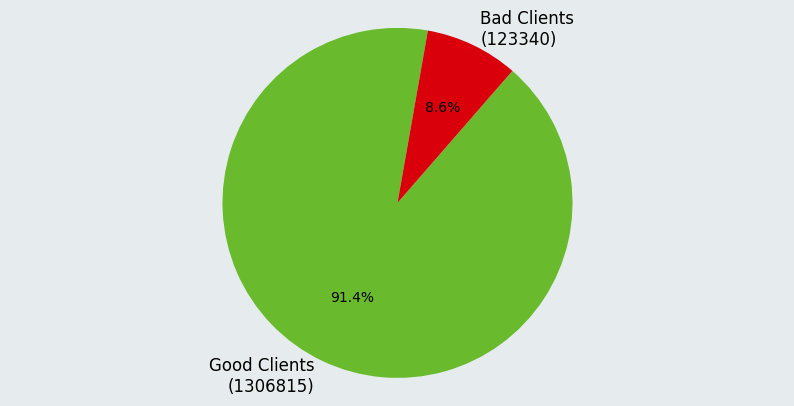

In [11]:
counts = train_full['TARGET'].value_counts()
fig, ax = plt.subplots(figsize=(10, 5))
fig.patch.set_facecolor('#e6ebed')
gbp = ['#69ba2d', '#d9000c']

wedges, texts, autotexts = ax.pie(counts,
                                   labels=['Good Clients', 'Bad Clients'],
                                   autopct='%1.1f%%',
                                   colors=gbp,
                                   startangle=80)

plt.axis('equal')
for i, text in enumerate(texts):
    text.set(text=texts[i].get_text() + f'\n({counts.iloc[i]})')
    texts[i].set_fontsize(12)
plt.show()

As we can see that Clients in our data is Dominated by Good Clients whose don't have payment difficulties. This also mean that our data class is imbalance, we have to handle this imbalance data later on.

In [62]:
num = train_full.select_dtypes(include='number')
ctg = train_full.select_dtypes(include='object')

In [63]:
# Assuming that 'TARGET' is your target variable
X = train_full.drop('TARGET', axis=1)
y = train_full['TARGET']

In [ ]:
train_clean1 = train_full.AVERAGE_DPD.fillna(0)
train_clean2 = ms.dropnan(train_full, 0.4)

train_missing = train_clean2[train_clean2.columns[train_clean2.isna().any()]] 
traincol = train_missing.columns


for col in traincol:
    if train_clean2[col].dtype == 'object':
        train_clean2[col].fillna(train_clean2[col].mode()[0], inplace=True)
    else:
        train_clean2[col].fillna(train_clean2[col].median(), inplace=True)

In [75]:
Xc1 = X.AVERAGE_DPD.fillna(0)
Xc2 = ms.dropnan(X, 0.4)

missingx = Xc2[Xc2.columns[Xc2.isna().any()]]
xcol = missingx.columns

for col in xcol:
    if Xc2[col].dtype == 'object':
        Xc2[col].fillna(Xc2[col].mode()[0], inplace=True)
    else:
        Xc2[col].fillna(Xc2[col].median(), inplace=True)

In [76]:
Xnum = Xc2.select_dtypes(include='number')
Xctg = Xc2.select_dtypes(include='object')

In [77]:
# Numerical 
# Create an instance of SelectKBest
selector = SelectKBest(score_func=f_classif, k=20)  # Change k to the number of top features you want

X_num_selected = selector.fit_transform(Xnum, y)

# Get the feature names
mask = selector.get_support()  # List of booleans
new_features = []  # The list of your K best features

for bool, feature in zip(mask, X.columns):
    if bool:
        new_features.append(feature)

print('The most important features are:', new_features)

The most important features are: ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT_x', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x', 'NAME_TYPE_SUITE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'WEEKDAY_APPR_PROCESS_START_x', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'ORGANIZATION_TYPE', 'FLAG_DOCUMENT_20']


In [60]:

# Create an instance of SelectKBest
selector = SelectKBest(score_func=f_classif, k=10)  # Change k to the number of top features you want

# Fit and transform the data
X_new = selector.fit_transform(X, y)

# Get the feature names
mask = selector.get_support()  # List of booleans
new_features = []  # The list of your K best features

for bool, feature in zip(mask, X.columns):
    if bool:
        new_features.append(feature)

print('The most important features are:', new_features)

ValueError: could not convert string to float: 'Cash loans'

### Good & Bad Clients Comparison by they Average Amount Application & Income

<Axes: xlabel='TARGET', ylabel='DAYS_LAST_DUE'>

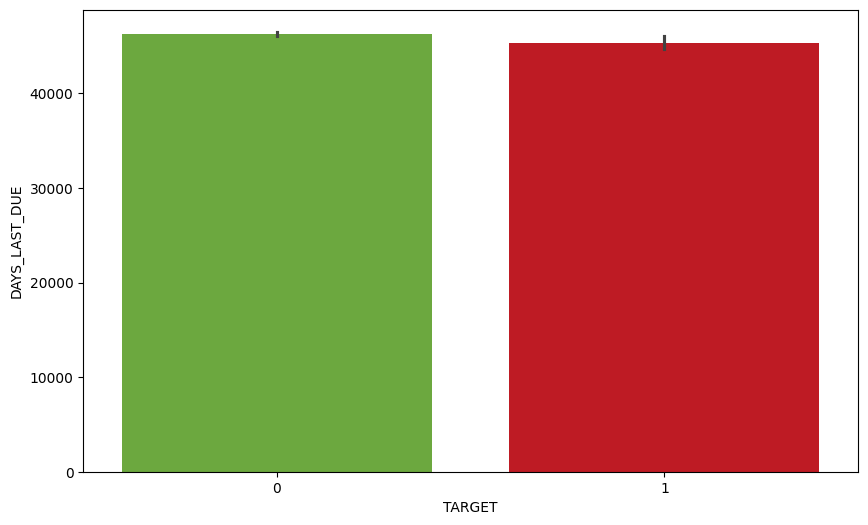

In [53]:
plt.figure(figsize=(10, 6))
sns.barplot(x='TARGET', y='DAYS_LAST_DUE', data=train_full, palette=gbp)

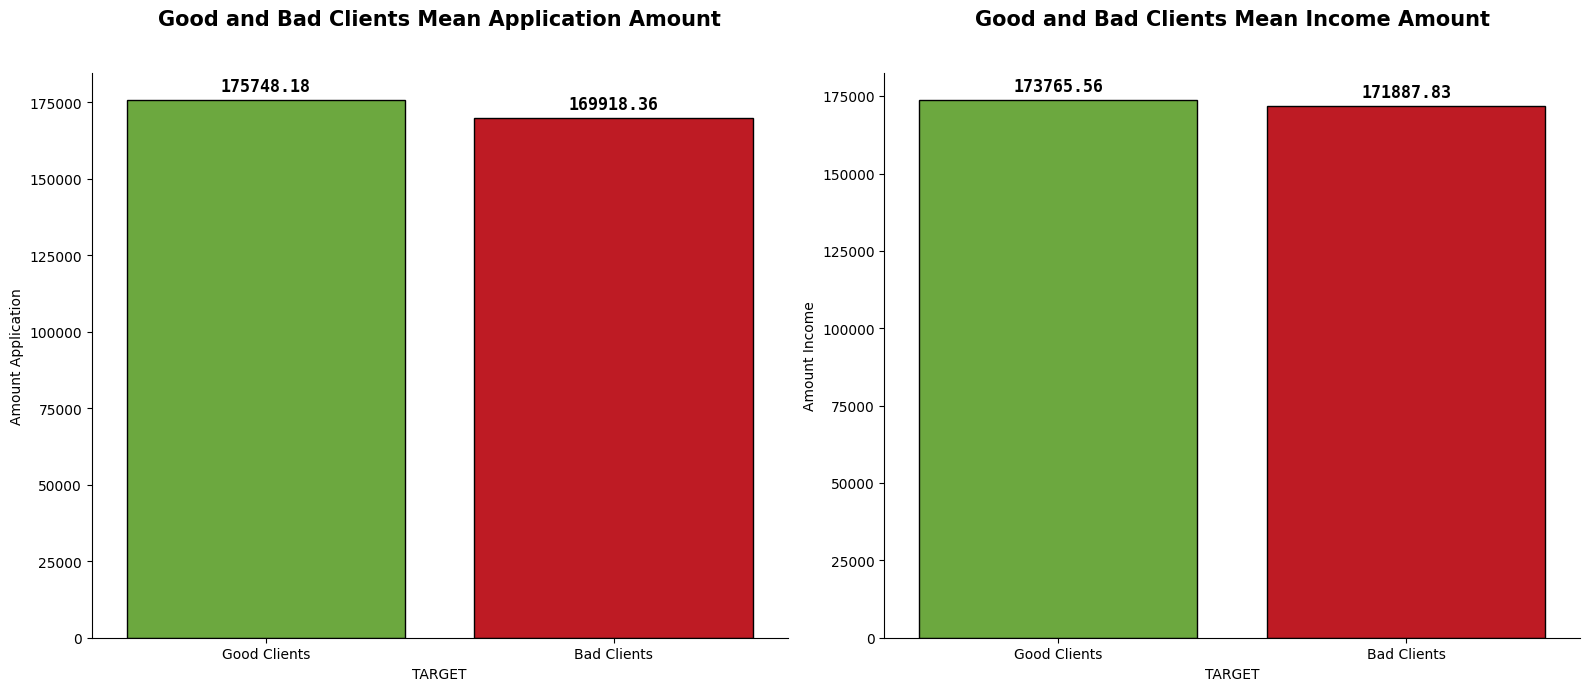

In [13]:
def create_plot(ax, data, x, y, title, ylabel):
    sns.barplot(x=x, y=y, data=data, ax=ax, palette=gbp, edgecolor='black')
    sns.despine()
    ax.set_title(title, fontsize=15, fontweight='bold', y=1.07)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Good Clients', 'Bad Clients'])
    ax.set_ylabel(ylabel)
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 10), 
                    textcoords = 'offset points',
                    fontweight='bold',
                    fontsize=12,
                    fontname='monospace')

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Group the data by 'TARGET' and calculate the mean of 'AMT_APPLICATION'
apl = train_full.groupby('TARGET')['AMT_APPLICATION'].mean().reset_index(name='MEAN_APPLICATION')
create_plot(axes[0], apl, 'TARGET', 'MEAN_APPLICATION', 'Good and Bad Clients Mean Application Amount', 'Amount Application')

# Group the data by 'TARGET' and calculate the mean of 'AMT_INCOME_TOTAL'
mi = train_full.groupby('TARGET')['AMT_INCOME_TOTAL'].mean().reset_index(name='MEAN_INCOME')
create_plot(axes[1], mi, 'TARGET', 'MEAN_INCOME', 'Good and Bad Clients Mean Income Amount', 'Amount Income')

# Finally, show the plot
plt.tight_layout()
plt.show()

**Interpretation** :<br>
There's no significance differences income between good clients and bad client, that mean the low income doesn't guarantee that the clients will be a bad clients.

### Good and Bad Clients Differences by their Cash Loan Purpose

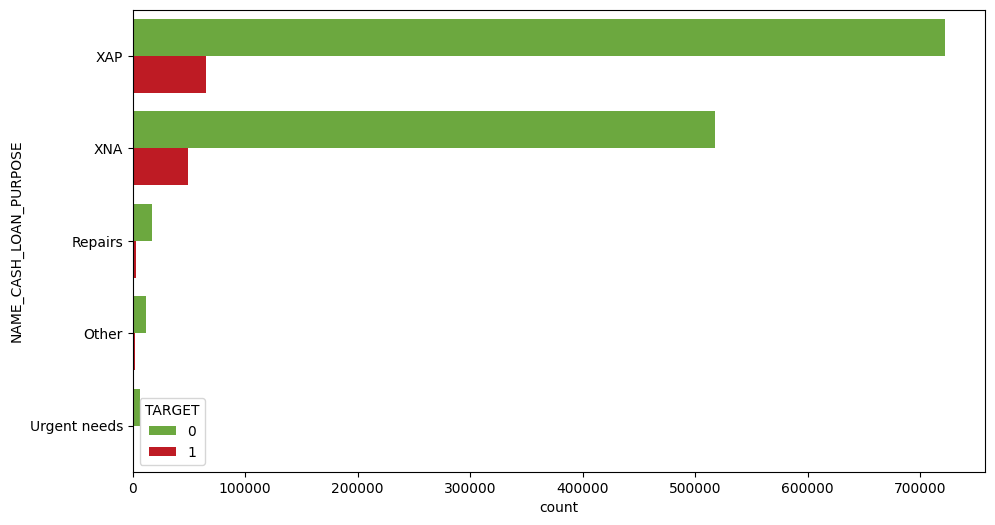

In [15]:
clp = train_full.NAME_CASH_LOAN_PURPOSE.value_counts().head(5)

plt.figure(figsize=(11, 6))
sns.countplot(y='NAME_CASH_LOAN_PURPOSE', hue='TARGET', data=train_full, palette=gbp, order=clp.index)
plt.show()

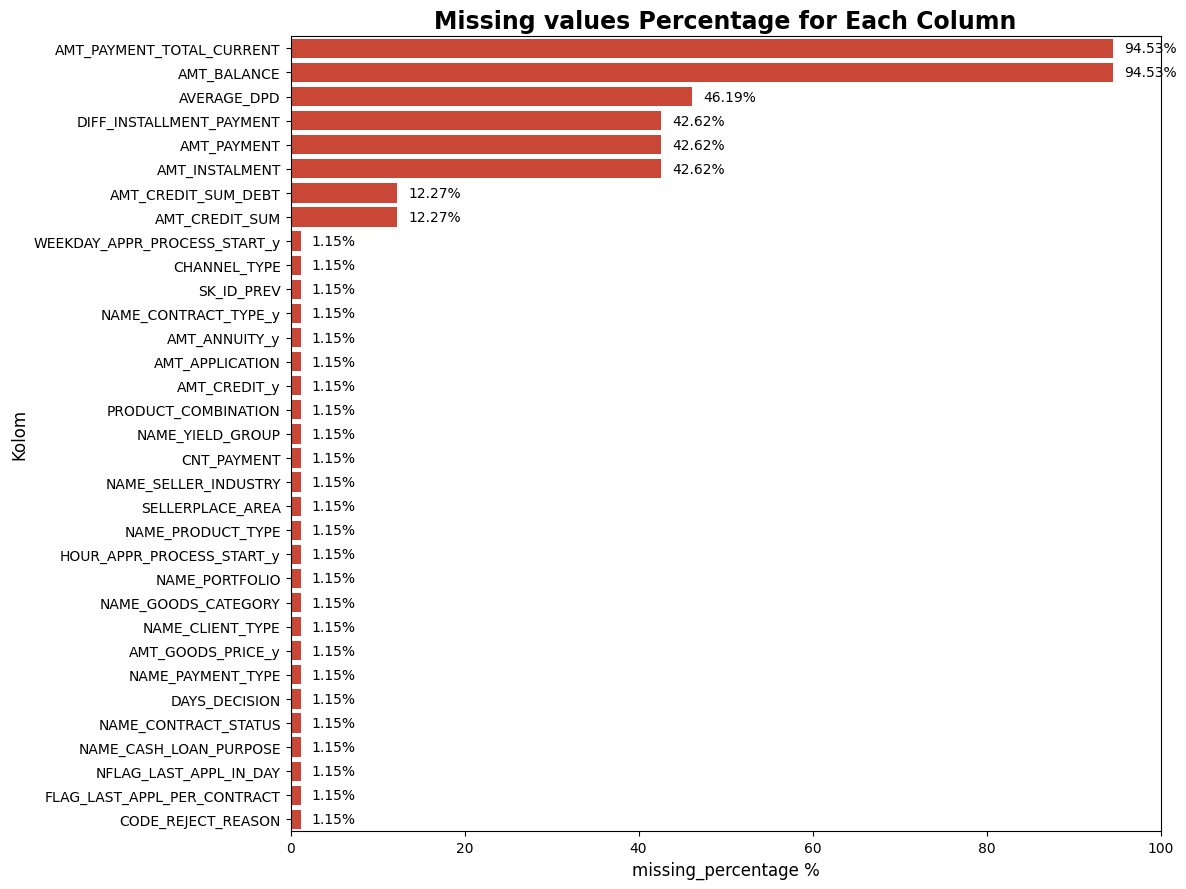

In [57]:
ms.plot_missing_percentage(train_full)

## Handle Missing Values

In [ ]:
tain_clean2.group

In [143]:
train_clean1 = train_full.AVERAGE_DPD.fillna(0)
train_clean2 = ms.dropnan(train_full, 0.4)

train_missing = train_clean2[train_clean2.columns[train_clean2.isna().any()]] 
traincol = train_missing.columns


for col in traincol:
    if train_clean2[col].dtype == 'object':
        train_clean2[col].fillna(train_clean2[col].mode()[0], inplace=True)
    else:
        train_clean2[col].fillna(train_clean2[col].median(), inplace=True)

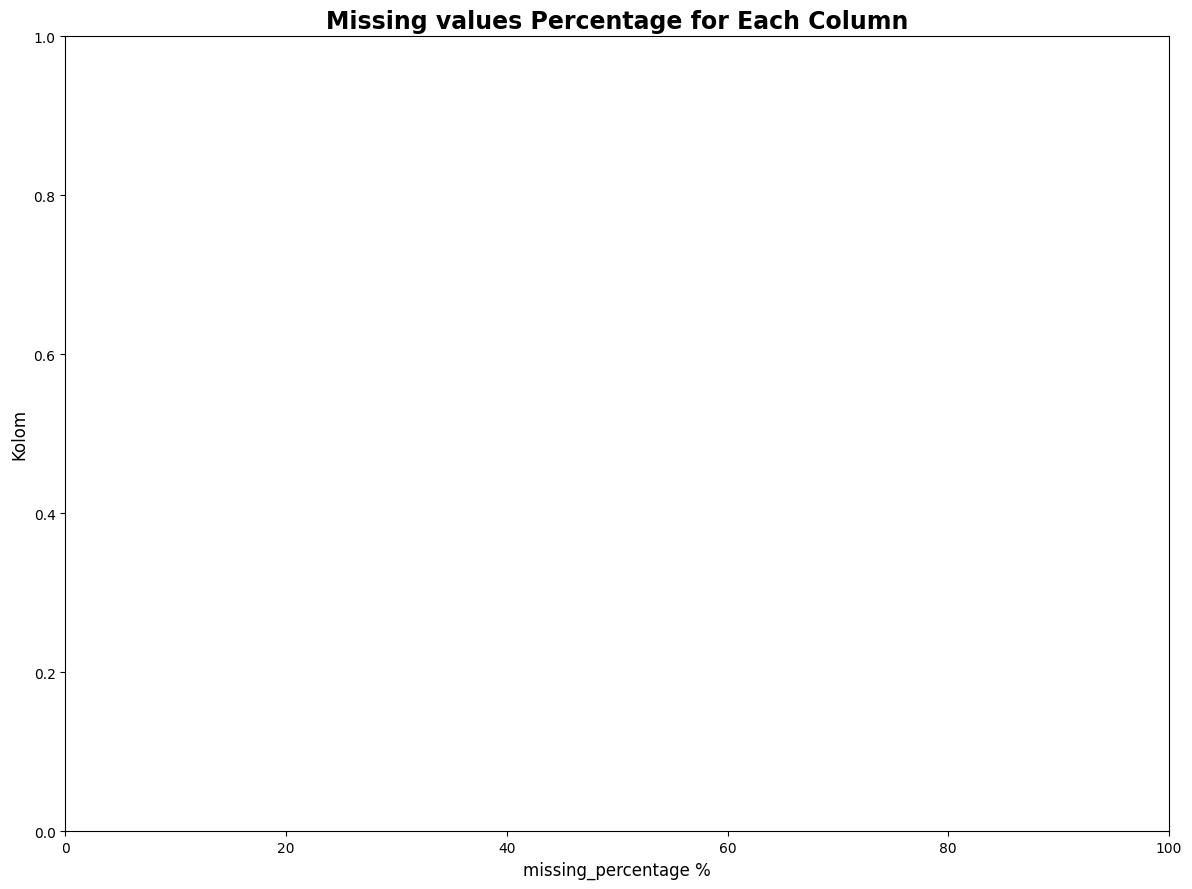

In [144]:
ms.plot_missing_percentage(train_clean2)

In [135]:
train_missing = train_clean2[train_clean2.columns[train_clean2.isna().any()]] 
train_missing

,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,SK_ID_PREV,NAME_CONTRACT_TYPE_y,AMT_ANNUITY_y,AMT_APPLICATION,AMT_CREDIT_y,AMT_GOODS_PRICE_y,WEEKDAY_APPR_PROCESS_START_y,HOUR_APPR_PROCESS_START_y,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION
0,865055.565,245781.00,1038818.0,Consumer loans,9251.775,179055.0,179055.0,179055.0,SATURDAY,9.0,Y,1.0,XAP,Approved,-606.0,XNA,XAP,New,Vehicles,POS,XNA,Stone,500.0,Auto technology,24.0,low_normal,POS other with interest
1,1017400.500,0.00,1810518.0,Cash loans,98356.995,900000.0,1035882.0,900000.0,FRIDAY,12.0,Y,1.0,XNA,Approved,-746.0,XNA,XAP,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1.0,XNA,12.0,low_normal,Cash X-Sell: low
2,1017400.500,0.00,2636178.0,Consumer loans,64567.665,337500.0,348637.5,337500.0,SUNDAY,17.0,Y,1.0,XAP,Approved,-828.0,Cash through the bank,XAP,Refreshed,Furniture,POS,XNA,Stone,1400.0,Furniture,6.0,middle,POS industry with interest
3,1017400.500,0.00,2396755.0,Consumer loans,6737.310,68809.5,68053.5,68809.5,SATURDAY,15.0,Y,1.0,XAP,Approved,-2341.0,Cash through the bank,XAP,Refreshed,Consumer Electronics,POS,XNA,Country-wide,200.0,Consumer electronics,12.0,middle,POS household with interest
4,189037.800,0.00,1564014.0,Consumer loans,5357.250,24282.0,20106.0,24282.0,FRIDAY,5.0,Y,1.0,XAP,Approved,-815.0,Cash through the bank,XAP,New,Mobile,POS,XNA,Regional / Local,30.0,Connectivity,4.0,middle,POS mobile without interest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1430150,3801919.500,1534913.01,2073384.0,Cash loans,16400.610,229500.0,254340.0,229500.0,THURSDAY,12.0,Y,1.0,XNA,Approved,-648.0,Cash through the bank,XAP,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1.0,XNA,24.0,middle,Cash X-Sell: middle
1430151,3801919.500,1534913.01,1708056.0,Revolving loans,2250.000,45000.0,45000.0,45000.0,SUNDAY,14.0,Y,1.0,XAP,Refused,-456.0,XNA,HC,Repeater,XNA,Cards,walk-in,Country-wide,20.0,Connectivity,0.0,XNA,Card Street
1430152,3801919.500,1534913.01,1296007.0,Cash loans,30737.655,765000.0,1067940.0,765000.0,FRIDAY,14.0,Y,1.0,Repairs,Refused,-171.0,Cash through the bank,HC,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1.0,XNA,60.0,low_normal,Cash Street: low
1430153,3801919.500,1534913.01,2631384.0,Cash loans,54022.140,1170000.0,1271929.5,1170000.0,FRIDAY,14.0,Y,1.0,XNA,Approved,-787.0,Cash through the bank,XAP,Repeater,XNA,Cash,x-sell,AP+ (Cash loan),6.0,XNA,36.0,low_normal,Cash X-Sell: low


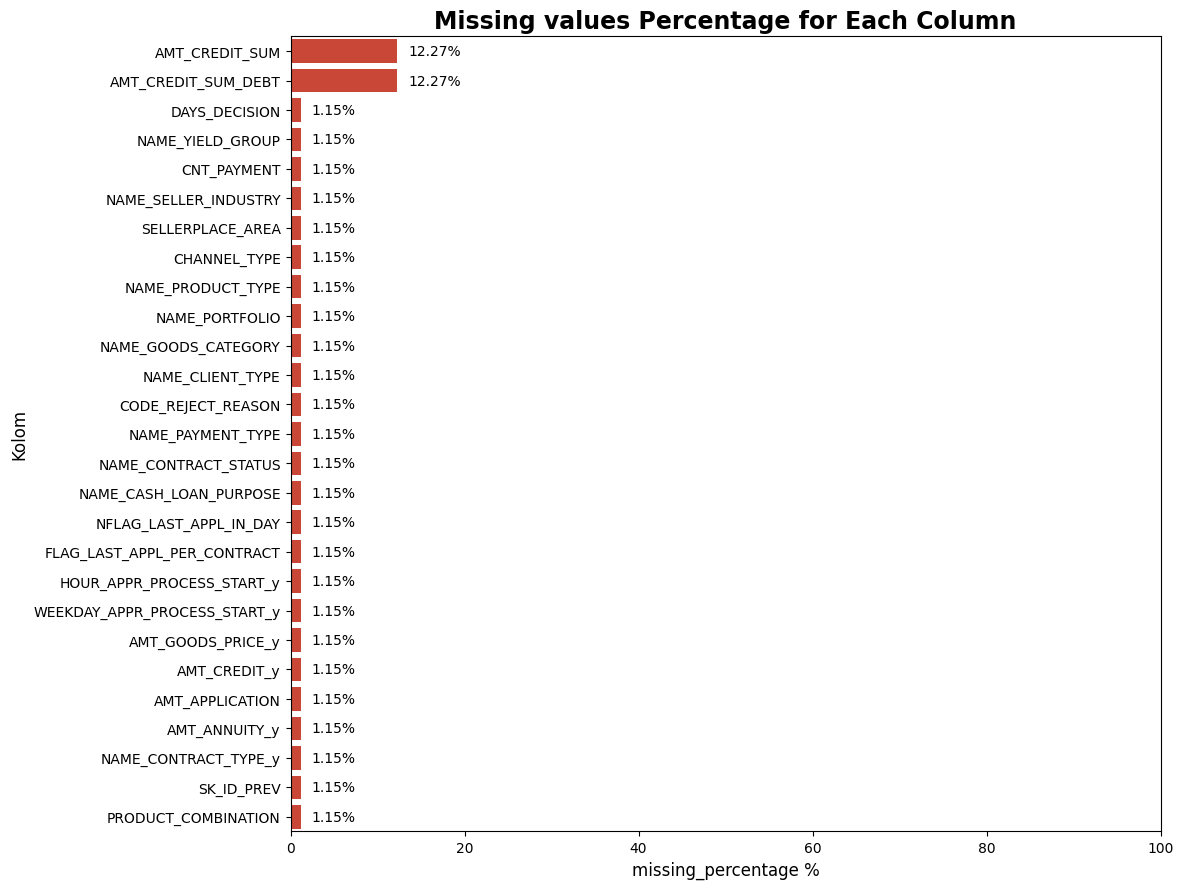

In [132]:
ms.plot_missing_percentage(train_clean2)

In [9]:
p_pos = pd.merge(previous, pos_cash, on='SK_ID_PREV', how='inner')
p_cb = pd.merge(previous, ccb, on='SK_ID_PREV', how='inner')
p_full = pd.merge(p_pos, p_cb, on='SK_ID_PREV', how='inner')

In [10]:
# Join previous_application based on SK_ID_CURR
joined_prev = app_train.merge(previous, on="SK_ID_CURR", how="left")

# Join behavioral data
joined_pcb = joined_prev.merge(
    pos_cash, on=["SK_ID_CURR", "SK_ID_PREV"], how="left"
)

joined_ccb = joined_pcb.merge(
    ccb, on=["SK_ID_CURR", "SK_ID_PREV"], how="left"
)

# Join installments data
joined_installments = joined_ccb.merge(
    installments, on=["SK_ID_CURR", "SK_ID_PREV"], how="left"
)

# Join bureau data
bureau_join = bureau.merge(bb, on="SK_ID_BUREAU", how="left")

joined_data = joined_installments.merge(
    bureau_join, on="SK_ID_CURR", how="left"
)

In [18]:
joined_data.shape

(8912295, 96)

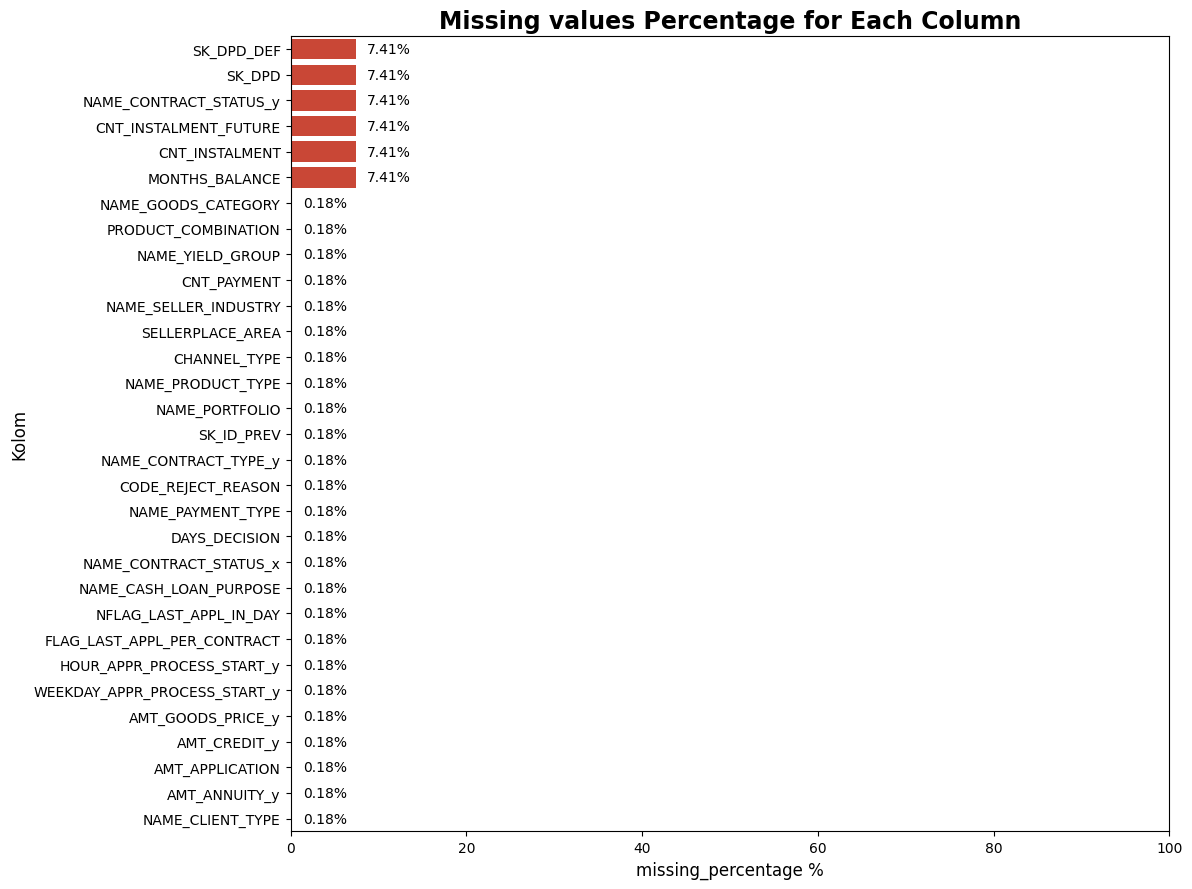

In [24]:
ms.plot_missing_percentage(joined_data)

In [11]:
# Join previous_application based on SK_ID_CURR
joined_data = app_train.merge(previous, on="SK_ID_CURR", how="left")

# Join behavioral data
joined_data = joined_data.merge(
    pos_cash, on=["SK_ID_CURR", "SK_ID_PREV"], how="left"
)

In [ ]:
joined_data.shape

In [5]:
p_full.shape

(13096669, 80)

In [10]:
p_pos.shape

(9660797, 33)

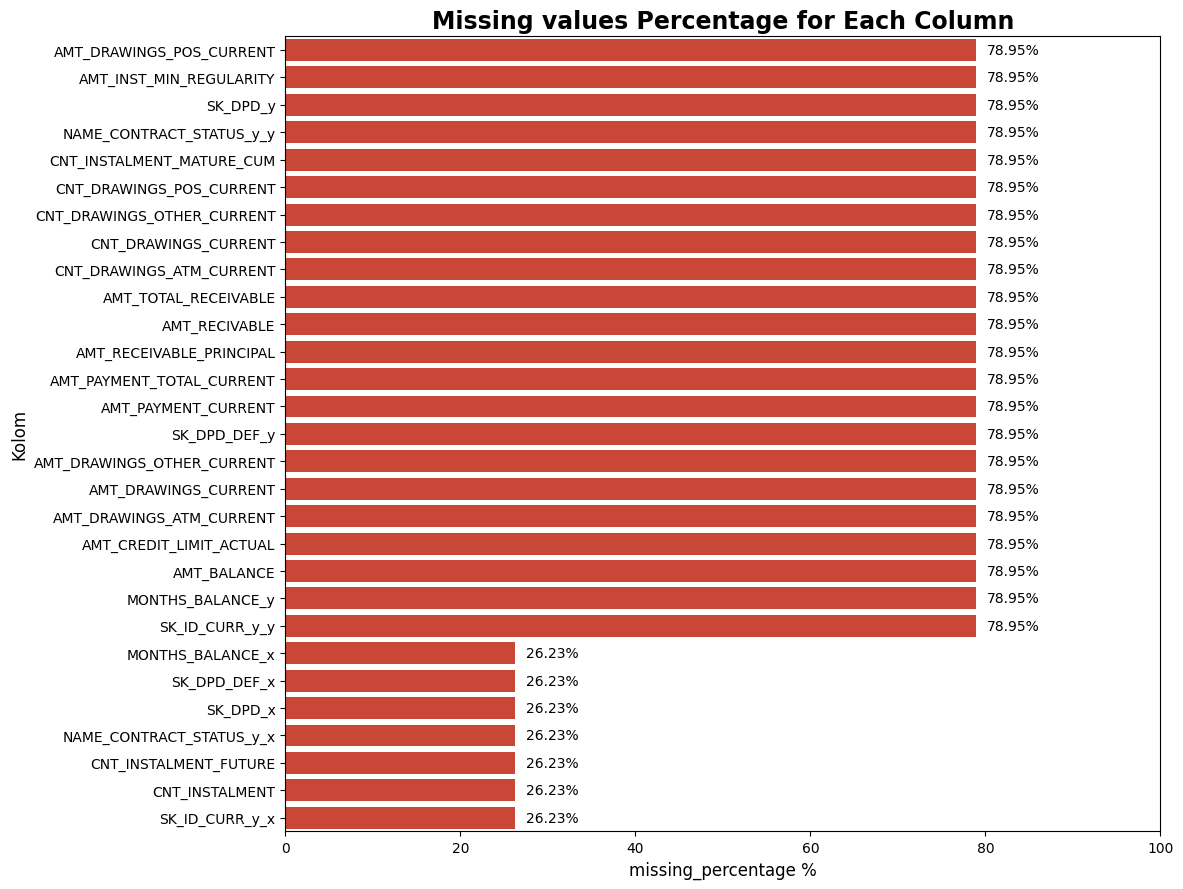

In [6]:
ms.plot_missing_percentage(p_full)